In [28]:
import numpy as np
import matplotlib.pyplot as plt

def load_signal_from_spek_abs(filename, I_mA=1.0, t_s=0.210,
                              A_pix=0.05*0.05, d=1.0,
                              res_sigma=0.0,
                              E_out=None,  # 可选：目标能量网格（keV），若给出将插值到该网格
                              plot=True, return_spectrum=True):
    """
    读取 Spek 光谱（E, flux[#/(keV·cm²·mAs)@1m]），保持绝对量，不做归一化。
    计算像素上的期望计数谱，并（可选）按 Poisson 采样出光子能量。
    返回:
      energies  : 采样得到的光子能量数组（可能为空，取决于期望计数）
      E_grid    : 能量网格（原始或插值后）
      flux_pix  : 像素处的通量谱  [#/keV]（已乘 A_pix, d, mAs）
      counts_exp: 每个能量 bin 的期望计数 [#]
    """

    # 1) 读 Spek 数据（假设两列：E[keV], flux）
    data = np.loadtxt(filename, skiprows=1)
    E_src   = data[:, 0].astype(float)
    flux_src = data[:, 1].astype(float)  # #/(keV·cm²·mAs) @1 m

    # 2) 距离/面积/曝光换算到像素上的单位能量通量
    mAs = I_mA * t_s
    flux_pix_src = flux_src * A_pix * (1.0 / d**2) * mAs   # #/keV per pixel (for this exposure)

    # 3) 可选：把谱插值到目标能量网格（比如更细的 0.5 keV）
    if E_out is not None:
        E_grid = np.asarray(E_out, float)
        flux_pix = np.interp(E_grid, E_src, flux_pix_src, left=0.0, right=0.0)
    else:
        E_grid = E_src
        flux_pix = flux_pix_src

    # 4) 计算各 bin 宽度 ΔE（最后一个 bin 取与前一相同）
    dE = np.diff(E_grid, append=E_grid[-1] + (E_grid[-1]-E_grid[-2] if E_grid.size>1 else 1.0))

    # 5) 每个 bin 的期望**绝对计数**（不归一化）
    counts_exp = flux_pix * dE  # [# per pixel]

    # 6) Poisson 采样得到实际光子数，并在各 bin 内均匀撒点
    n_per_bin = np.random.poisson(np.maximum(counts_exp, 0.0))
    total_n = int(n_per_bin.sum())
    energies = np.empty(total_n, dtype=float)
    idx = 0
    for i, n in enumerate(n_per_bin):
        if n <= 0: 
            continue
        e0 = E_grid[i]
        e1 = E_grid[i] + dE[i]
        energies[idx:idx+n] = e0 + np.random.rand(n) * (e1 - e0)
        idx += n

    # 7) 能量分辨率（可选）
    if res_sigma > 0 and energies.size > 0:
        energies = np.random.normal(energies, res_sigma)
        energies = energies[energies > 0]

    # 8) 画图（绝对量）
    if plot:
        # fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        # ax.step(E_grid, flux_pix, where='post', label="Flux per pixel [#/keV]", linewidth=1.6)
        # ax.set_xlabel("Energy (keV)")
        # ax.set_ylabel("Flux per pixel [#/keV]")
        # ax.grid(True, alpha=0.3)
        # ax.legend(loc="best")
        # plt.tight_layout()
        # plt.show()

        # # 期望计数谱
        # fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        # ax.step(E_grid, counts_exp, where='post', label="Expected counts per bin", linewidth=1.6)
        # ax.set_xlabel("Energy bin start (keV)")
        # ax.set_ylabel("Counts per bin [#]")
        # ax.grid(True, alpha=0.3)
        # ax.legend(loc="best")
        # plt.tight_layout()
        # plt.show()

        # 抽样到的能量直方图（同样画**绝对计数**）
        if energies.size > 0:
            ax = plt.figure(figsize=(8,4)).gca()
            ax.hist(energies, bins=len(E_grid), range=(E_grid[0], E_grid[-1]+dE[-1]),
                    density=False, alpha=0.5, label=f"Sampled (N={energies.size})")
            ax.set_xlabel("Energy (keV)")
            ax.set_ylabel("Counts")
            ax.legend(); ax.grid(True, alpha=0.3)
            plt.tight_layout(); plt.show()

    return (energies, E_grid, flux_pix, counts_exp) if return_spectrum else energies


模拟光子数: 160000


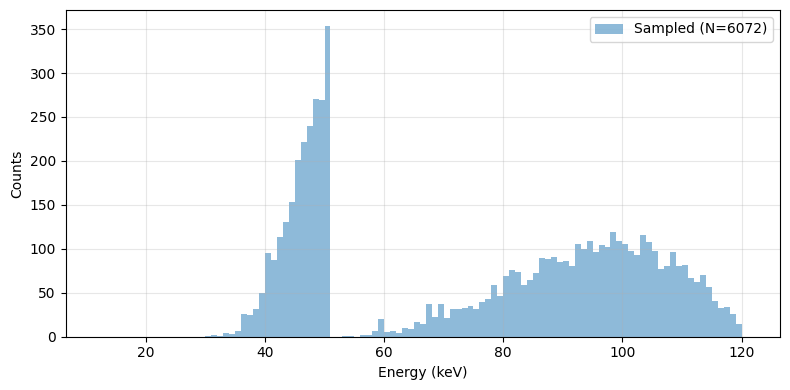

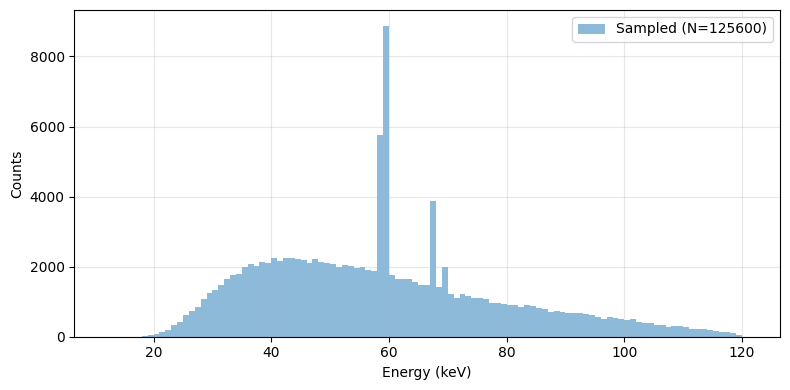

In [29]:

# ---------------- 参数 ---------------- 
integral_time = 400e-6  # 积分时间[s]   400（us）
dead_time = 25e-9       # 死时间[s]     15 ns
rate = 400e6            # 最大输入光子率 (photons/s)
sid = 0.4               # [m]
lenth_pixel = 340e-4    # 积分时间[cm]   340（um）

n_photons = int(integral_time * rate)
print("模拟光子数:", n_photons)
# ---------------- 信号 + 噪声源 ---------------- 

signal_120_Gd, E, flux_pix, counts = load_signal_from_spek_abs(
    "spectrum_filtered_Gd_0_6mm.txt",
    # I_mA = 20.0, t_s = integral_time,
    # A_pix = lenth_pixel * lenth_pixel, d = sid,
    res_sigma=0.0,
    E_out=None,       # 或 np.arange(10, 121, 0.5) 做插值
    plot=True
)

signal_120, E, flux_pix, counts = load_signal_from_spek_abs(
    "spek_120.txt",
    # I_mA = 20.0, t_s = integral_time,
    # A_pix = lenth_pixel * lenth_pixel, d = sid,
    res_sigma=0.0,
    E_out=None,       # 或 np.arange(10, 121, 0.5) 做插值
    plot=True
)

# 噪声 
noise = np.random.normal(25, 5, int(n_photons*0.3))   # 噪声峰

# events_120_Gd = np.concatenate([signal_120_Gd, noise])
# events_120    = np.concatenate([signal_120, noise]) 

events_120_Gd = np.concatenate([signal_120_Gd])
events_120    = np.concatenate([signal_120])  



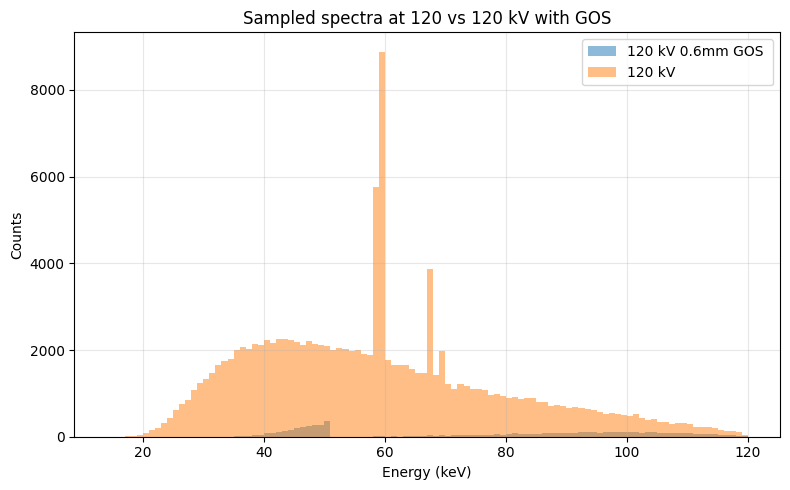

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# --- 公共能量轴（统一 bins） ---
if len(signal_120_Gd) == 0 or len(signal_120) == 0:
    raise ValueError("有一个样本为空，检查前面的采样参数/期望计数。")

emin = min(signal_120_Gd.min(), signal_120.min())
emax = max(signal_120_Gd.max(), signal_120.max())
bin_width = 1.0  # keV：你也可以改成 0.5 等
bins = np.arange(np.floor(emin), np.ceil(emax) + bin_width, bin_width)

# --- 叠加直方图 ---
plt.figure(figsize=(8,5))
plt.hist(signal_120_Gd, bins=bins, density=False, alpha=0.5,
         label="120 kV 0.6mm GOS ", histtype="stepfilled")
plt.hist(signal_120, bins=bins, density=False, alpha=0.5,
         label="120 kV ", histtype="stepfilled")

plt.xlabel("Energy (keV)")
plt.ylabel("Counts" )  # 若 density=False 改成 "Counts"
plt.title("Sampled spectra at 120 vs 120 kV with GOS")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [31]:
# ---------------- 积分谱计算函数（考虑死时间） ----------------
def integral_spectrum(events, thresholds, tau, T, mode="ideal", poisson_noise=False):
    spectrum = []
    for thr in thresholds:
        # 阈值以上的光子数
        N_thr = np.sum(events >= thr)
        # 当前输入光子率
        R_thr = N_thr / integral_time  

        if mode == "ideal":
            R_obs = R_thr
        elif mode == "nonpar":
            R_obs = R_thr / (1 + R_thr * tau)
        elif mode == "par":
            R_obs = R_thr * np.exp(-R_thr * tau)
        else:
            raise ValueError("Unknown mode")
        
 # 转换回总计数
        N_obs = R_obs * T
  
        # 转换回计数率
        R_final = N_obs / T

        # 转换回总计数数目
        spectrum.append(R_final)
    return np.array(spectrum)

In [32]:
# ---------------- 阈值范围 ----------------
thresholds = np.linspace(0, 150, 300)

# ---------------- 三种模式的积分谱 ----------------
# 理想计数模式
ideal_int_120 = integral_spectrum(events_120, thresholds, dead_time, integral_time, mode="ideal",poisson_noise=True)
ideal_diff_120 =     -np.gradient(ideal_int_120, thresholds)

ideal_int_100 = integral_spectrum(events_120_Gd, thresholds, dead_time, integral_time, mode="ideal",poisson_noise=True)
ideal_diff_100 =     -np.gradient(ideal_int_100, thresholds)

# 非瘫痪模式
Non_Par_int_120 = integral_spectrum(events_120, thresholds, dead_time, integral_time, mode="nonpar",poisson_noise=True)
Non_Par_diff_120 =     -np.gradient(Non_Par_int_120, thresholds)

Non_Par_int_100 = integral_spectrum(events_120_Gd, thresholds, dead_time, integral_time, mode="nonpar",poisson_noise=True)
Non_Par_diff_100 =     -np.gradient(Non_Par_int_100, thresholds)

#瘫痪模式
Par_int_120 = integral_spectrum(events_120, thresholds, 35e-9, integral_time, mode="par",poisson_noise=True)
Par_diff_120 =     -np.gradient(Par_int_120, thresholds)

Par_int_100 = integral_spectrum(events_120_Gd, thresholds, dead_time, integral_time, mode="par",poisson_noise=True)
Par_diff_100 =     -np.gradient(Par_int_100, thresholds)

# Par_int_noise = integral_spectrum(noise_dark, thresholds, dead_time, integral_time, mode="par",poisson_noise=True)
# diff_par_noise = -np.gradient(Par_int_noise, thresholds) 

In [33]:
def plot_spectrum_subplot(ax, x, curves, xlabel, ylabel, title):
    """
    在子图 ax 上绘制多条曲线
    参数:
        ax     : matplotlib subplot 对象
        x      : 横坐标 (ndarray)
        curves : [(y, style, label)] 的列表
        xlabel, ylabel, title : 坐标轴标题 & 图标题
    """
    for y, style, label in curves:
        ax.plot(x, y/1e6, style, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)


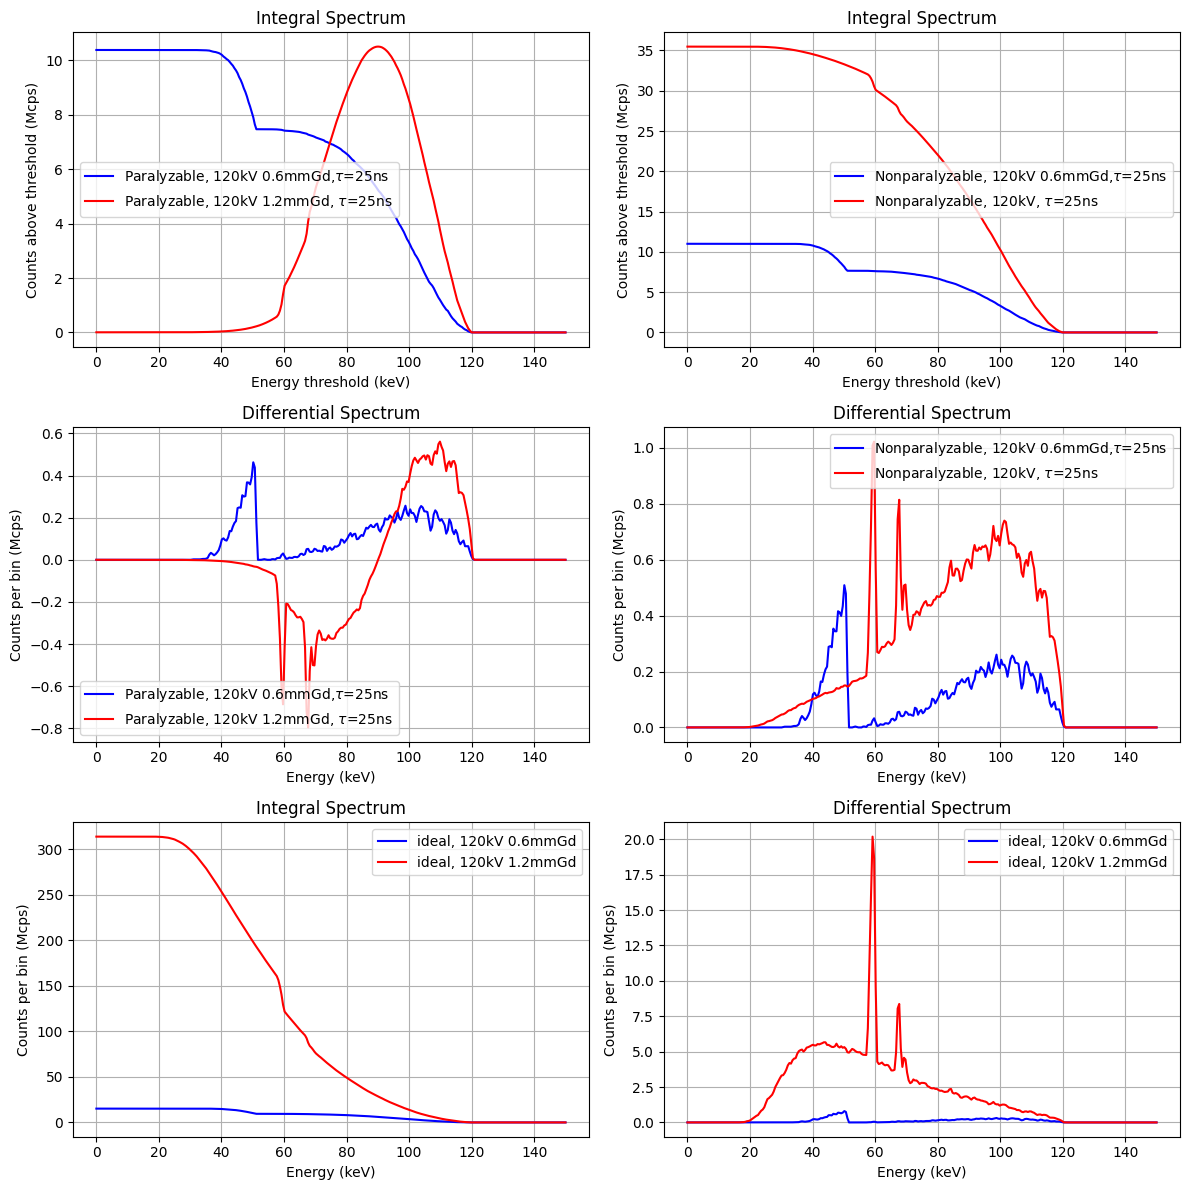

In [34]:
# 定义绘图配置：每个子图一条记录
plot_configs = [
    # (axis位置, y列表, xlabel, ylabel, title)
    (321, [  # 左上 (row=2, col=2, index=1)
        (Par_int_100, 'b', r"Paralyzable, 120kV 0.6mmGd,$\tau$=25ns"),
        (Par_int_120, 'r', r"Paralyzable, 120kV 1.2mmGd, $\tau$=25ns"),
     ], "Energy threshold (keV)", "Counts above threshold (Mcps)", "Integral Spectrum"),

    (322, [
        (Non_Par_int_100, 'b', r"Nonparalyzable, 120kV 0.6mmGd,$\tau$=25ns"),
        (Non_Par_int_120, 'r', r"Nonparalyzable, 120kV, $\tau$=25ns"),
     ], "Energy threshold (keV)", "Counts above threshold (Mcps)", "Integral Spectrum"),

    (323, [
        (Par_diff_100, 'b', r"Paralyzable, 120kV 0.6mmGd,$\tau$=25ns"),
        (Par_diff_120, 'r', r"Paralyzable, 120kV 1.2mmGd, $\tau$=25ns"),
     ], "Energy (keV)", "Counts per bin (Mcps)", "Differential Spectrum"),

    (324, [
        (Non_Par_diff_100, 'b', r"Nonparalyzable, 120kV 0.6mmGd,$\tau$=25ns"),
        (Non_Par_diff_120, 'r', r"Nonparalyzable, 120kV, $\tau$=25ns"),
     ], "Energy (keV)", "Counts per bin (Mcps)", "Differential Spectrum"),
    (325, [
     (ideal_int_100, 'b', r"ideal, 120kV 0.6mmGd"),
     (ideal_int_120, 'r', r"ideal, 120kV 1.2mmGd"),
     ], "Energy (keV)", "Counts per bin (Mcps)", "Integral Spectrum"),
    (326, [
     (ideal_diff_100, 'b', r"ideal, 120kV 0.6mmGd"),
     (ideal_diff_120, 'r', r"ideal, 120kV 1.2mmGd"),
     ], "Energy (keV)", "Counts per bin (Mcps)", "Differential Spectrum"),

]

# ---------------- 绘图 ----------------
plt.figure(figsize=(12, 12))  # 高度调大些，避免挤

for subplot_id, curves, xlabel, ylabel, title in plot_configs:
    ax = plt.subplot(subplot_id)
    plot_spectrum_subplot(ax, thresholds, curves, xlabel, ylabel, title)

plt.tight_layout()
plt.show()


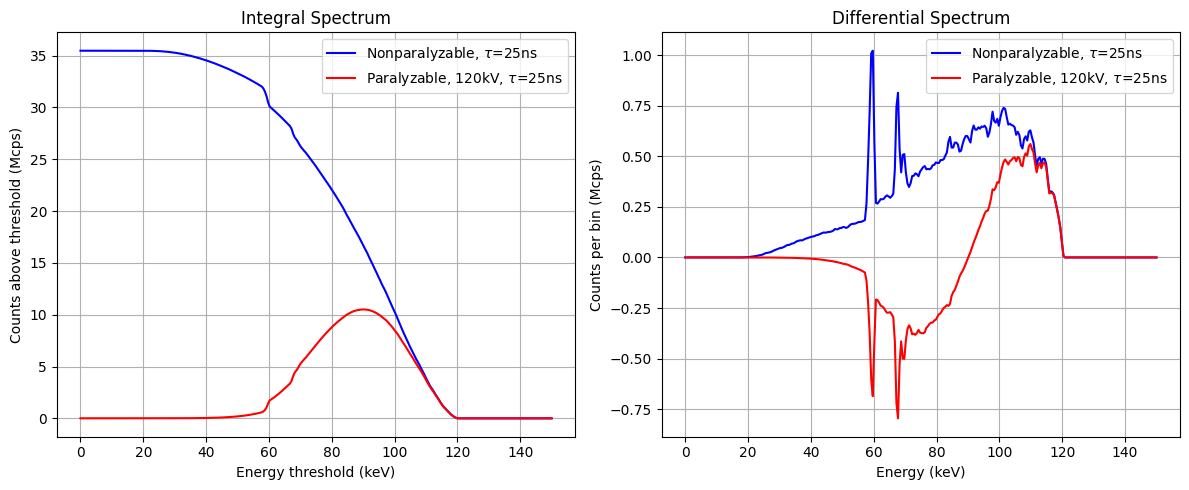

In [35]:
# ---------------- 比较不同计数模式的图片 ----------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# 积分谱
plot_spectrum_subplot(
    ax1, thresholds,
    [
        (Non_Par_int_120, 'b', r"Nonparalyzable, $\tau$=25ns"),
        (Par_int_120, 'r', r"Paralyzable, 120kV, $\tau$=25ns"),
    ],
    xlabel="Energy threshold (keV)",
    ylabel="Counts above threshold (Mcps)",
    title="Integral Spectrum"
)

# 微分谱
plot_spectrum_subplot(
    ax2, thresholds,
    [
        (Non_Par_diff_120, 'b', r"Nonparalyzable, $\tau$=25ns"),
        (Par_diff_120, 'r', r"Paralyzable, 120kV, $\tau$=25ns"),
    ],
    xlabel="Energy (keV)",
    ylabel="Counts per bin (Mcps)",
    title="Differential Spectrum"
)

plt.tight_layout()
plt.show()

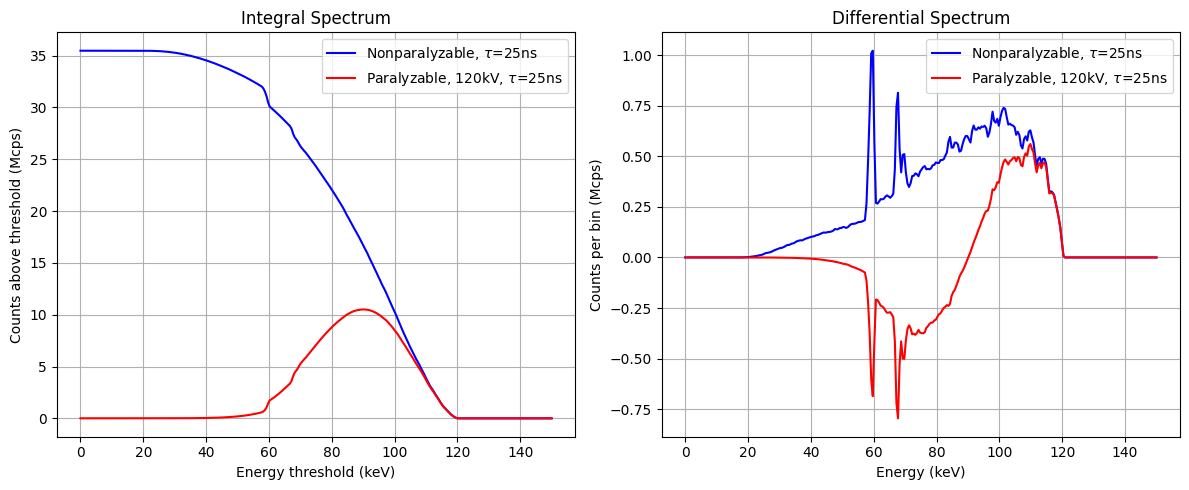

In [36]:

# ---------------- 绘图 ----------------
plt.figure(figsize=(12,5))

# 积分谱
plt.subplot(1,2,1)
# plt.plot(thresholds, ideal_int_120/1e6, 'k', label="Ideal detector")
plt.plot(thresholds, Non_Par_int_120/1e6, 'b', label=r"Nonparalyzable, $\tau$=25ns")
plt.plot(thresholds, Par_int_120/1e6, 'r', label=r"Paralyzable, 120kV, $\tau$=25ns")
# plt.plot(thresholds, Par_int_noise/1e6, 'g', label=r"Paralyzable, dark, $\tau$=25ns")
# plt.plot(thresholds, Par_int_noise/1e6, 'g', label=r"Paralyzable, $\tau$=15ns")
plt.xlabel("Energy threshold (keV)")
plt.ylabel("Counts above threshold (Mcps)")
plt.title("Integral Spectrum")
plt.legend()
plt.grid(True)

# 微分谱
plt.subplot(1,2,2)
# plt.plot(thresholds, ideal_diff_120/1e6, 'k', label="Ideal detector")
plt.plot(thresholds, Non_Par_diff_120/1e6, 'b', label=r"Nonparalyzable, $\tau$=25ns")
plt.plot(thresholds, Par_diff_120/1e6, 'r', label=r"Paralyzable, 120kV, $\tau$=25ns")
# plt.plot(thresholds, diff_par_noise/1e6, 'g', label=r"Paralyzable, $\tau$=15ns")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin (Mcps)")
plt.title("Differential Spectrum")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
